In [ ]:
!pip install opendatasets

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import opendatasets as od

In [ ]:
Deepfake_path = od.download("https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces")

Skipping, found downloaded files in "./140k-real-and-fake-faces" (use force=True to force download)


In [ ]:
deepfake_train = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'
deepfake_val = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid'
deepfake_test = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'

In [ ]:
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    deepfake_train,
    shuffle=True,
    batch_size=32,
    image_size=(256,256)
)
val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    deepfake_val,
    shuffle=True,
    batch_size=32,
    image_size=(256,256)
)
test_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    deepfake_test,
    shuffle=True,
    batch_size=32,
    image_size=(256,256)
)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [ ]:
class_names_train = train_dataset.class_names
class_names_val=val_dataset.class_names
class_names_test = test_dataset.class_names


In [ ]:
test_dataset=test_dataset.take(78)
val_dataset=val_dataset.take(78)
train_dataset=train_dataset.take(313)

Exact numbers of samples in Training set:
fake: 4952
real: 4952


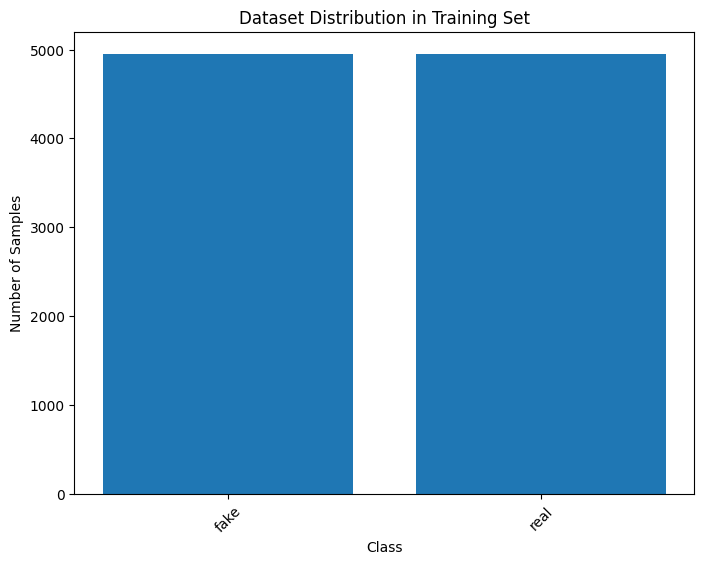

Exact numbers of samples in Validation set:
fake: 1269
real: 1269


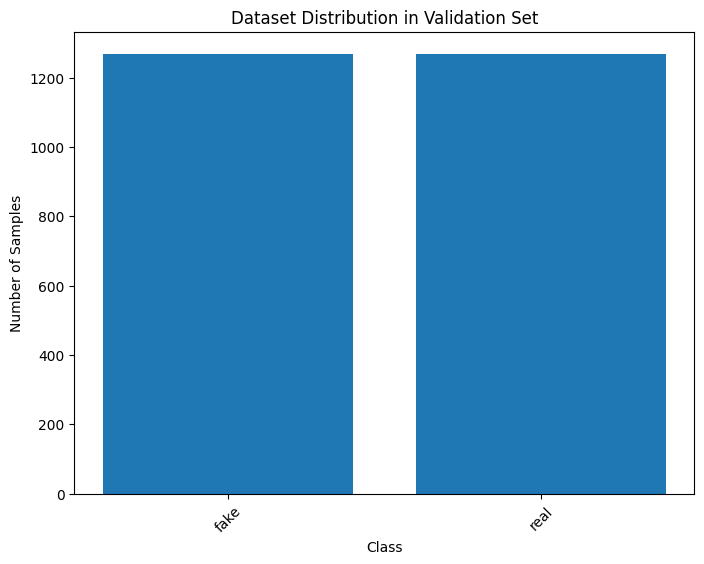

Exact numbers of samples in Test set:
fake: 1231
real: 1231


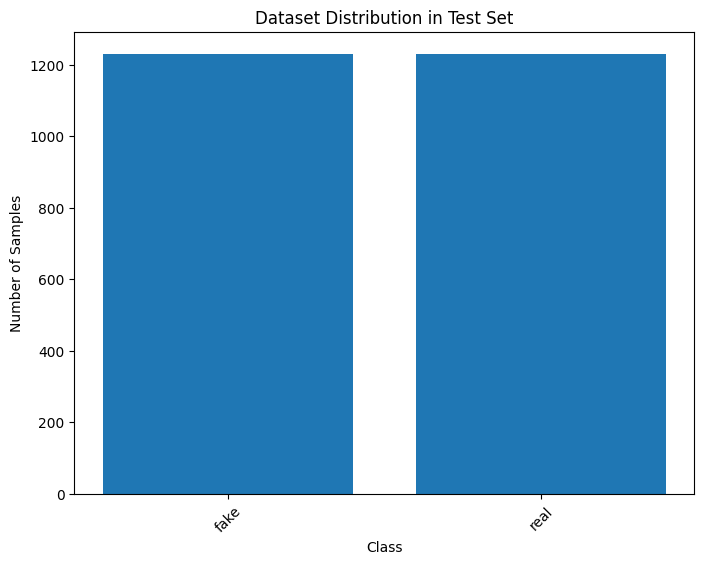

In [ ]:



# Function to plot dataset distribution
def plot_dataset_distribution(dataset, class_names, set_name):
    # Count the number of samples for each class
    class_counts = np.zeros(len(class_names))
    for images, labels in dataset:
        class_counts += np.sum(labels.numpy(), axis=0)

    # Print the exact numbers
    print(f"Exact numbers of samples in {set_name} set:")
    for i, count in enumerate(class_counts):
        print(f"{class_names[i]}: {int(count)}")

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, class_counts)
    plt.title(f'Dataset Distribution in {set_name} Set')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.show()

# Plot distribution for training set
plot_dataset_distribution(train_dataset, class_names_train, 'Training')

# Plot distribution for validation set
plot_dataset_distribution(val_dataset, class_names_val, 'Validation')

# Plot distribution for test set
plot_dataset_distribution(test_dataset, class_names_test, 'Test')


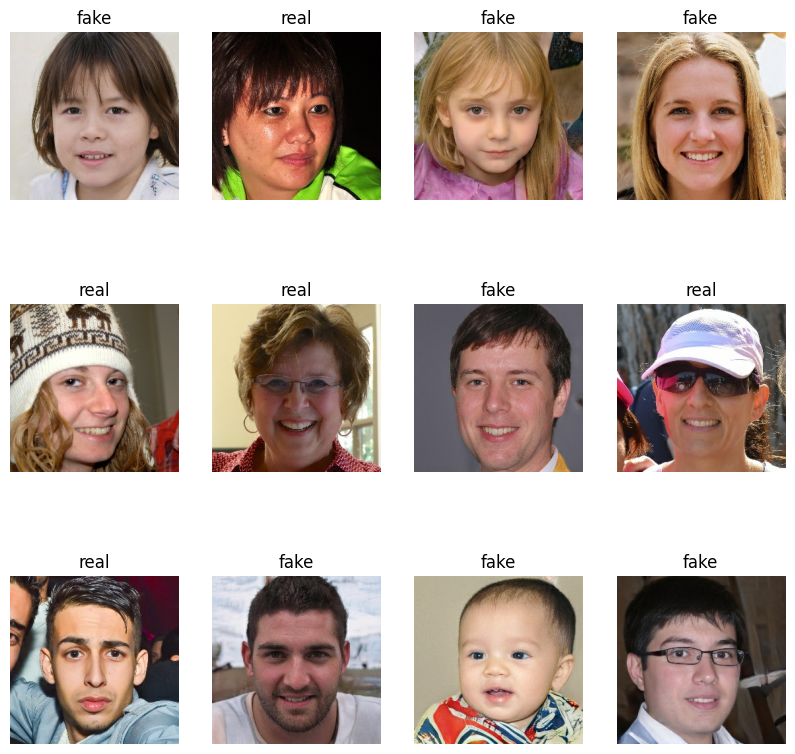

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names_train[labels_batch[i]])
        plt.axis("off")

In [ ]:
#optimization
train_dataset = train_dataset.cache().shuffle(5000).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#normalization(augmentation)
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),#it will take care of predicted image if it is not 256/256
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
#ekta image er koyek type er image banabe ja theke train o predict korte easy hoy/ robust
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomCrop(224, 224),
  layers.Lambda(lambda x: tf.image.sobel_edges(x)[..., 0]),
])

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=80

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),  # Increased complexity
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Added another dropout layer
    layers.Dense(2, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 128)         0         
 g2D)                                                 

In [ ]:
#compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adjusted learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:


# Define a callback to save the best model during training
checkpoint_filepath = 'best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',  # Monitor validation accuracy to determine the best model
    mode='max',
    verbose=1
)

# Train the model with the callback
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=80,
    callbacks=[model_checkpoint_callback]  # Pass the callback to the fit method
)




Epoch 1/80
313/313 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.5088
Epoch 1: val_accuracy improved from -inf to 0.55729, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 78s 161ms/step - loss: 0.6942 - accuracy: 0.5088 - val_loss: 0.6920 - val_accuracy: 0.5573
Epoch 2/80
313/313 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.5277
Epoch 2: val_accuracy improved from 0.55729 to 0.56010, saving model to best_model.h5
313/313 [==============================] - 52s 165ms/step - loss: 0.6911 - accuracy: 0.5277 - val_loss: 0.6872 - val_accuracy: 0.5601
Epoch 3/80
313/313 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.5698
Epoch 3: val_accuracy improved from 0.56010 to 0.64543, saving model to best_model.h5
313/313 [==============================] - 51s 163ms/step - loss: 0.6796 - accuracy: 0.5698 - val_loss: 0.6424 - val_accuracy: 0.6454
Epoch 4/80
313/313 [==============================] - ETA: 0s - loss: 0.6615 - accuracy: 0.6042
Epoch 4: val_accuracy did not improve from 0.64543
313/313 [==============================] - 43s 138ms/step - loss: 0.6615 - accuracy: 0.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

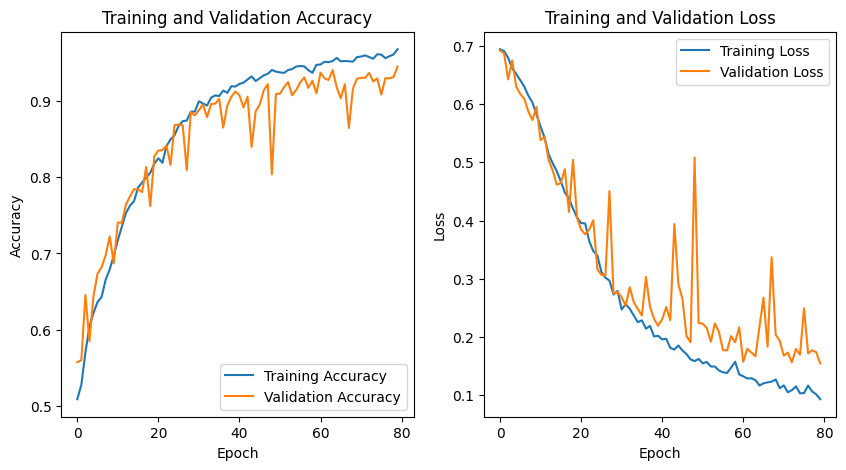

In [ ]:
EPOCHS=80
plt.figure(figsize=(10, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history.history['loss'], label='Training Loss')
plt.plot(range(EPOCHS), history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()
